In [44]:
import os
import matplotlib.pyplot as plt
from superlet import superlet, scale_from_period
import mne 
# from mne import create_info
import numpy as np
# from burst_detection import extract_bursts
from fooof import FOOOF
# from autoreject import AutoReject
import scipy.io

import pandas as pd

from zapline_iter import zapline_until_gone

In [11]:
data_dir='/home/common/bonaiuto/stop_go_bursts/data/'
output_dir='/home/qmoreau/stop_go_bursts/'

In [12]:
SSD = scipy.io.loadmat(os.path.join(data_dir, 'Dataset_1/Study5_BEH_data/S1_SSD_stop.mat'))
SSD_data = SSD['num_align2']
df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])  # Assign column names if known
# average value over all trials
SSD_val = df_SSD['Value'].mean()
SSD_val

131.97916666666666

In [14]:
data_path = os.path.join(data_dir, 'Dataset_1/Study5_EEG_data/')
electrodes = ['C3', 'F4'] # , 'C4', 'F3', 'FCz'
subject_ids =  ['S1', 'S2', 'S3', 'S5', 'S6', 'S7', 'S8', 'S10', 'S11','S13', 'S14', 'S15']

In [17]:
subject_id=subject_ids[0]
subject_file = data_path + subject_id + '_stop_eeg_emg_ica_brain.set'
print(f"Processing {subject_id}")
raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})

Processing S1
Reading /home/common/bonaiuto/stop_go_bursts/data/Dataset_1/Study5_EEG_data/S1_stop_eeg_emg_ica_brain.fdt


/home/bonaiuto/miniconda3/envs/auditory_laminar/lib/python3.7/site-packages/mne/io/eeglab/eeglab.py:152: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if d.get("type", None) != 'FID':
/home/bonaiuto/tmp/ipykernel_55201/3190478549.py:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
/home/bonaiuto/tmp/ipykernel_55201/3190478549.py:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
/home/bonaiuto/tmp/ipykernel_55201/3190478549.py:4: RuntimeWarning: Not setting positions of 3 eog channels found in montage:
['HEOG L', 'HEOG R', 'VEOG']
Consider setting the channel types

<RawEEGLAB | S1_stop_eeg_emg_ica_brain.fdt, 62 x 2016057 (3937.6 s), ~87 kB, data not loaded>

In [21]:
SSD = scipy.io.loadmat(os.path.join(data_dir, f'Dataset_1/Study5_BEH_data/{subject_id}_SSD_stop.mat'))
SSD_data = SSD['num_align2']
df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])  # Assign column names if known
# average value over all trials
SSD_val = df_SSD['Value'].mean()

In [25]:
SSD_val

131.97916666666666

In [31]:
builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(montage, verbose=False)
events, event_id = mne.events_from_annotations(raw)
# shift 'L_cueCG' and 'R_cueCG' events by SSD value
events_shift = events.copy()
for i in range(len(events)):
    if events_shift[i][2] == 1 or events_shift[i][2] == 9:
        events_shift[i][0] = events_shift[i][0] + SSD_val

epochs = mne.Epochs(raw, events=events, picks = 'eeg', event_id = event_id, tmin=-1, tmax=2, baseline = None, event_repeated='merge', preload = True)
epochs = mne.preprocessing.compute_current_source_density(epochs)

Used Annotations descriptions: ['L_cueCG', 'L_cueFS', 'L_cueGE', 'L_cueGM', 'L_cueSS', 'L_resp', 'L_stopsigFS', 'L_stopsigSS', 'R_cueCG', 'R_cueFS', 'R_cueGE', 'R_cueGM', 'R_cueSS', 'R_cue_stop', 'R_resp', 'R_stopsig', 'R_stopsigFS', 'R_stopsigSS', 'boundary', 'fix']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
4827 matching events found
No baseline correction applied
0 projection items activated
Loading data for 4827 events and 1537 original time points ...
1 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 0.0 40.1 mm
Origin device coordinates:    0.0 0.0 40.1 mm


In [32]:
epochs

<Epochs |  4826 events (all good), -1 - 2 sec, baseline off, ~3.26 GB, data loaded,
 'L_cueCG': 515
 'L_cueFS': 103
 'L_cueGE': 1
 'L_cueGM': 6
 'L_cueSS': 86
 'L_resp': 601
 'L_stopsigFS': 102
 'L_stopsigSS': 86
 'R_cueCG': 548
 'R_cueFS': 94
 and 12 more events ...>

In [33]:
frequencies = np.arange(1, 40, 1) 
n_cycles = frequencies / 2  

SS = epochs['L_stopsigSS', 'R_stopsigSS']
FS = epochs['L_stopsigFS', 'R_stopsigFS']
GO = epochs['L_cueCG', 'R_cueCG']

conditions = {'SS': SS, 'FS': FS, 'GO': GO}

In [34]:
SS

<Epochs |  179 events (all good), -1 - 2 sec, baseline off, ~123.9 MB, data loaded,
 'L_stopsigSS': 86
 'R_stopsigSS': 93>

In [35]:
condition_name='SS'
condition=conditions[condition_name]
electrode=electrodes[0]

In [38]:
times = condition.times
ch_idx = condition.ch_names.index(electrode)
trials = condition.get_data()[:, ch_idx, :]

sfreq = condition.info['sfreq']
max_freq = 120
foi = np.linspace(1, max_freq, 120)
scales = scale_from_period(1/foi)
tf_trials = []

for trial in trials:
    tf = superlet(
        trial, sfreq, scales, 40, c_1=4, adaptive=True
    )
    tf_trials.append(np.single(np.abs(tf)))
tf_trials = np.array(tf_trials)

In [77]:
average_psd = np.average(tf_trials, axis=(2, 0))

ff = FOOOF()
ff.fit(foi, average_psd, [1, 120])
ap = 10 ** ff._ap_fit 


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



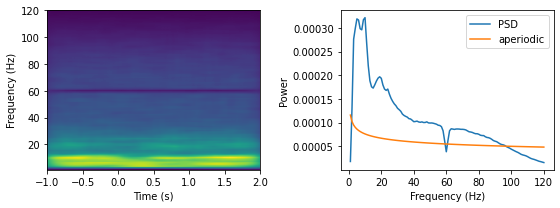

In [78]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(np.mean(tf_trials,axis=0),aspect='auto',extent=[times[0], times[-1], foi[0], foi[-1]], origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.subplot(1,2,2)
plt.plot(foi,average_psd,label='PSD')
plt.plot(foi,ap,label='aperiodic')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()

In [79]:
average_psd = np.average(tf_trials, axis=(2, 0))

ff = FOOOF()
ff.fit(foi, average_psd, [3, 50])
ap = 10 ** ff._ap_fit 


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



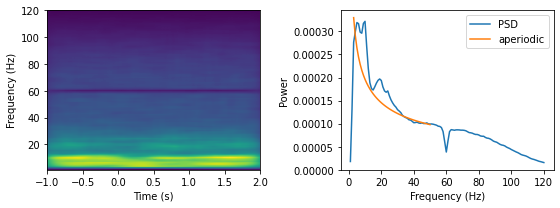

In [80]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(np.mean(tf_trials,axis=0),aspect='auto',extent=[times[0], times[-1], foi[0], foi[-1]], origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.subplot(1,2,2)
plt.plot(foi, average_psd,label='PSD')
plt.plot(foi[(foi>=3) & (foi<=50)], ap,label='aperiodic')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()

In [ ]:
for subject_id in subject_ids:
    print(f"\nProcessing {subject_id}...")

    # Create subject output directory
    subject_out_dir = os.path.join(output_dir, subject_id)
    os.makedirs(subject_out_dir, exist_ok=True)

    # Load EEG Data
    subject_file = os.path.join(data_path, f"{subject_id}_stop_eeg_emg_ica_brain.set")
    raw = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=True)
    raw.rename_channels({'FP1': 'Fp1', 'FP2': 'Fp2'})

    # Load SSD Data
    ssd_path = os.path.join(data_dir, f'Dataset_1/Study5_BEH_data/{subject_id}_SSD_stop.mat')
    SSD = scipy.io.loadmat(ssd_path)
    SSD_data = SSD['num_align2']
    df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])
    SSD_val = df_SSD['Value'].mean()

    # Set Montage
    montage = mne.channels.make_standard_montage("easycap-M1")
    raw.set_montage(montage, verbose=False)

    # Extract Events and Shift Event Timing
    events, event_id = mne.events_from_annotations(raw)
    events_shift = events.copy()
    for i in range(len(events)):
        if events[i][2] in [1, 9]:  # Adjust only L_cueCG and R_cueCG
            events_shift[i][0] += int(SSD_val * sfreq)  # Convert SSD value to sample index

    # Epoching
    epochs = mne.Epochs(raw, events=events_shift, picks='eeg', event_id=event_id,
                        tmin=-1, tmax=2, baseline=None, event_repeated='merge', preload=True)
    
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    # Apply zapline filtering across all channels and epochs
    filtered_data, iterations = zapline_until_gone(
        data, target_freq=24, sfreq=epochs.info['sfreq'],
        win_sz=5, spot_sz=1.5, viz=True, prefix="all_channels", max_iter=3
    )

    # Create a new Epochs object with filtered data
    epochs_filtered = mne.EpochsArray(filtered_data, epochs.info, events=epochs.events, event_id=epochs.event_id, tmin=epochs.tmin, baseline=epochs.baseline)

    # Replace epochs with filtered epochs for further analysis
    epochs = epochs_filtered

    # Compute Current Source Density (CSD)
    epochs = mne.preprocessing.compute_current_source_density(epochs)

    # Define Conditions
    conditions = {
        'SS': epochs['L_stopsigSS', 'R_stopsigSS'],
        'FS': epochs['L_stopsigFS', 'R_stopsigFS'],
        'GO': epochs['L_cueCG', 'R_cueCG']
    }

    for cond, epoch_data in conditions.items():
        print(f"Processing {subject_id} - Condition: {cond}")

        # Create condition-specific directory
        cond_out_dir = os.path.join(subject_out_dir, cond)
        os.makedirs(cond_out_dir, exist_ok=True)

        # Compute PSD before filtering
        data = epoch_data.get_data()  # Shape: (n_epochs, n_channels, n_times)

        psd_before, freqs = psd_array_welch(data, sfreq=sfreq, fmin=1, fmax=50, verbose=False,
                                            n_fft=int(sfreq * 2), n_overlap=int(sfreq))

        # Change working directory to save Zapline figures in the correct folder
        os.chdir(cond_out_dir)

        # Apply Zapline filtering at 24 Hz and save figures in cond_out_dir
        prefix = f"{subject_id}_{cond}_zapline"
        filtered_data, iterations = zapline_until_gone(data, target_freq=24, sfreq=sfreq,
                                                       win_sz=5, spot_sz=1.5, viz=True, prefix=prefix, max_iter=3)

        # Restore working directory to avoid issues with later file operations
        os.chdir(output_dir)

        # Compute PSD after filtering
        psd_after, _ = psd_array_welch(filtered_data, sfreq=sfreq, fmin=1, fmax=50, verbose=False,
                                       n_fft=int(sfreq * 2), n_overlap=int(sfreq))

        # Convert to dB
        psd_before_db = 10 * np.log10(psd_before)
        psd_after_db = 10 * np.log10(psd_after)

        # Average across trials
        psd_before_db_mean = np.mean(psd_before_db, axis=0)  
        psd_after_db_mean = np.mean(psd_after_db, axis=0) 
        
        # Average across channels
        psd_before_db_mean_av = np.mean(psd_before_db_mean, axis=0)  
        psd_after_db_mean_av = np.mean(psd_after_db_mean, axis=0)  

        # Plot and Save PSD before and after filtering
        psd_fig_path = os.path.join(cond_out_dir, f"{subject_id}_{cond}_psd_comparison.png")
        plt.figure(figsize=(10, 5))
        plt.plot(freqs, psd_before_db_mean_av, label="Before Filtering", alpha=0.7)
        plt.plot(freqs, psd_after_db_mean_av, label="After Filtering", alpha=0.7, linestyle="dashed")
        plt.axvline(24, color="r", linestyle="--", label="Filtered Freq (24 Hz)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power Spectral Density (dB)")
        plt.legend()
        plt.title(f"{subject_id} - {cond}: PSD Before and After Zapline Filtering at 24 Hz\n(Converged in {iterations} iterations)")
        plt.savefig(psd_fig_path, dpi=300)
        plt.close()  # Close the figure after saving

        print(f"Saved results for {subject_id} - {cond} in {cond_out_dir}")

In [ ]:
from joblib import Parallel, delayed

# Define Paths and Variables
data_dir = '/home/common/bonaiuto/stop_go_bursts/data/'
output_dir = '/home/qmoreau/stop_go_bursts/'
data_path = os.path.join(data_dir, 'Dataset_1/Study5_EEG_data/')
plot_dir = "/home/qmoreau/stop_go_bursts/fooof_plots/"
os.makedirs(plot_dir, exist_ok=True)

subject_ids = ['S1', 'S2', 'S3', 'S5', 'S6', 'S7', 'S8', 'S10', 'S11', 'S13', 'S14', 'S15']
epoch_types = ['GO', 'SS', 'FS']

# Create expanded lists
subject_list = [subj for subj in subject_ids for _ in epoch_types]
epoch_list = epoch_types * len(subject_ids)

def process_subject_epoch(subject_id, epoch_type):

    subject_out_dir = os.path.join(output_dir, subject_id)
    os.makedirs(subject_out_dir, exist_ok=True)

    # Load EEG Data
    subject_file = os.path.join(data_path, f"{subject_id}_stop_eeg_emg_ica_brain.set")
    raw = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=True)
    raw.rename_channels({'FP1': 'Fp1', 'FP2': 'Fp2'})

    # Load SSD Data
    ssd_path = os.path.join(data_dir, f'Dataset_1/Study5_BEH_data/{subject_id}_SSD_stop.mat')
    SSD = scipy.io.loadmat(ssd_path)
    SSD_val = np.mean(SSD['num_align2'][:, 2])

    # Set Montage
    raw.set_montage(mne.channels.make_standard_montage("easycap-M1"), verbose=False)

    # Extract Events and Shift Event Timing
    events, event_id = mne.events_from_annotations(raw)
    events[:, 0] += np.where(np.isin(events[:, 2], [1, 9]), int(SSD_val * 512), 0)

    # Epoching
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=-1, tmax=2, 
                         picks='eeg', baseline=None, event_repeated='merge', preload=True)

    # Apply Zapline filtering
    epochs._data, _ = zapline_until_gone(epochs.get_data(), target_freq=24, sfreq=512, 
                                         win_sz=5, spot_sz=1.5, viz=False, prefix=f"{subject_id}_epoch", max_iter=3)

    # Compute Current Source Density (CSD)
    epochs = mne.preprocessing.compute_current_source_density(epochs)

    # Select specific condition
    conditions = {
        'SS': epochs['L_stopsigSS', 'R_stopsigSS'],
        'FS': epochs['L_stopsigFS', 'R_stopsigFS'],
        'GO': epochs['L_cueCG', 'R_cueCG']
    }

    if epoch_type not in conditions:
        return None  # Skip if invalid epoch type

    condition = conditions[epoch_type]
    results = []

    electrodes = ['C3', 'F4']
    for electrode in electrodes:
        ch_idx = condition.ch_names.index(electrode)
        trials = condition.get_data()[:, ch_idx, :]
        foi = np.linspace(1, 120, 120)
        scales = scale_from_period(1 / foi)

        # Parallelize over epochs
        tf_trials = Parallel(n_jobs=-1)(
            delayed(lambda trial: np.abs(superlet(trial, condition.info['sfreq'], scales, 40, 4, adaptive=True)))(trial)
            for trial in trials
        )
        tf_trials = np.array(tf_trials)

        average_psd = np.mean(tf_trials, axis=(0, 2))

        # Fit FOOOF model
        ff = FOOOF()
        ff.fit(foi, average_psd, [3, 50])
        interpolated_ap = 10 ** (ff.aperiodic_params_[0] - ff.aperiodic_params_[1] * np.log10(foi))

        # Extract periodic component
        psd_periodic = np.maximum(average_psd - interpolated_ap, 0)

        search_range = np.where((foi >= 10) & (foi <= 33))[0]
        beta_lims = [13, 30]

        bursts = extract_bursts(
            trials, tf_trials[:, search_range], condition.times,
            foi[search_range], beta_lims, interpolated_ap[search_range].reshape(-1, 1), 512
        )
        bursts['condition'] = np.tile(epoch_type, bursts['trial'].shape)
        bursts['electrode'] = np.tile(electrode, bursts['trial'].shape)
        bursts['subject'] = np.tile(subject_id, bursts['trial'].shape)
        bursts['experiment'] = np.tile('Exp1', bursts['trial'].shape)
        bursts['epochs'] = np.tile('Stop', bursts['trial'].shape)

        results.append(bursts)

    return results

# Run in parallel over (subject, epoch) pairs
n_jobs = 3
bursts_all_results_laplac = Parallel(n_jobs=n_jobs)(
    delayed(process_subject_epoch)(subj, ep) for subj, ep in zip(subject_list, epoch_list)
)

# Flatten and save results
bursts_all_results_laplac = [item for sublist in bursts_all_results_laplac if sublist for item in sublist]
np.save(f'{output_dir}/bursts_all_results_laplac.npy', bursts_all_results_laplac)

print("Processing complete.")